# Domain adaptation transforms

It is possible to perform style transfer without the use of Neural networks.

Resulting imagews do not look as ideal but could be generated on the fly in a reasonable time.

In [ ]:
import random

import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import cv2

import albumentations as A

In [ ]:
def visualize(image):
    plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(image)

In [ ]:
def load_rgb(image_path):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
image1 = load_rgb("../images/park1.jpeg")
image2 = load_rgb("../images/rain2.jpeg")

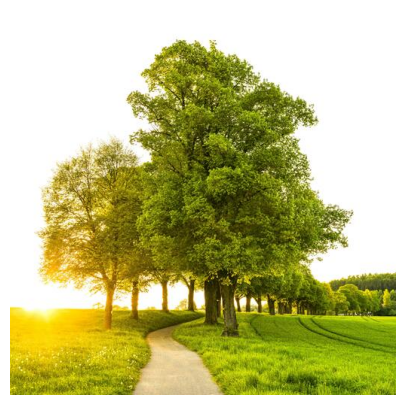

In [ ]:
visualize(image1)

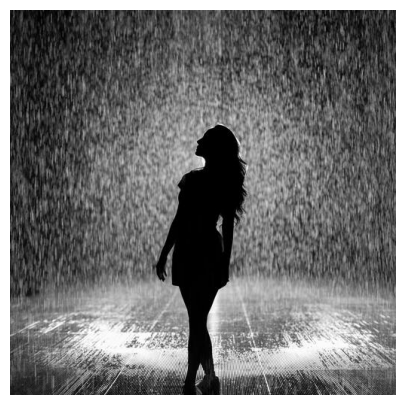

In [ ]:
visualize(image2)

## Historgram matching

This process adjusts the pixel values of an input image to align its histogram with that of a reference image. When dealing with multi-channel images, this alignment occurs separately for each channel, provided that both the input and the reference image have an identical number of channels.

[Documentation](https://albumentations.ai/docs/api_reference/augmentations/domain_adaptation/#albumentations.augmentations.domain_adaptation.HistogramMatching)

In [ ]:
transform = A.Compose([A.HistogramMatching(reference_images=[image2], 
                                           read_fn = lambda x: x, 
                                           p=1,
                                           blend_ratio=(0.3, 0.3)
                                          )], p=1)

In [ ]:
transformed = transform(image=image1)["image"]

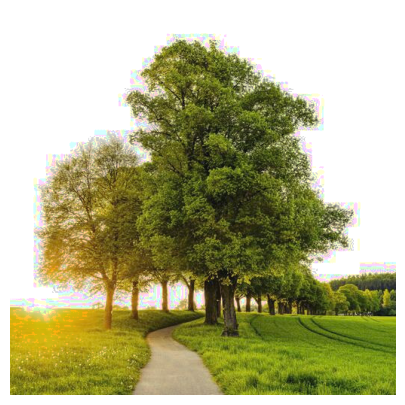

In [ ]:
visualize(transformed)

# Fourier Domain Adaptation (FDA)

![](https://github.com/YanchaoYang/FDA/blob/master/demo_images/FDA.png?raw=true)

Fourier Domain Adaptation (FDA) for simple "style transfer" in the context of unsupervised domain adaptation (UDA).
    FDA manipulates the frequency components of images to reduce the domain gap between source and target datasets, 
    effectively adapting images from one domain to closely resemble those from another without altering their semantic content.
    
This transform is particularly beneficial in scenarios where the training (source) and testing (target) images come from different distributions, such as synthetic versus real images, or day versus night scenes. Unlike traditional domain adaptation methods that may require complex adversarial training, FDA achieves domain alignment by swapping low-frequency components of the Fourier transform between the source and target images. This technique has shown to improve the performance of models on the target domain, particularly for tasks like semantic segmentation, without additional training for domain invariance.

[Documentation](https://albumentations.ai/docs/api_reference/augmentations/domain_adaptation/#albumentations.augmentations.domain_adaptation.FDA)


In [ ]:
transform = A.Compose([A.FDA(reference_images=[image1], read_fn = lambda x: x, p=1, beta_limit=(0.2, 0.2))], p=1)

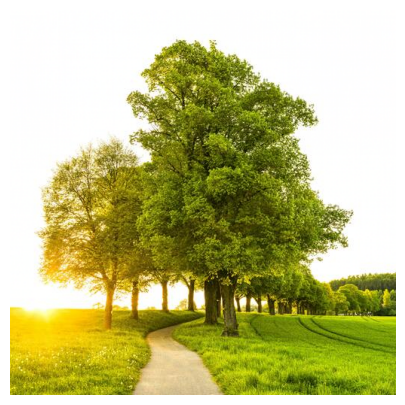

In [ ]:
transformed = transform(image=image1)["image"]
visualize(transformed)

In [ ]:
(transformed - image1).mean()

55.401878356933594

## PixelDistribution

Performs pixel-level domain adaptation by aligning the pixel value distribution of an input image
with that of a reference image. This process involves fitting a simple statistical (such as PCA, StandardScaler, or MinMaxScaler) to both the original and the reference images, transforming the original image with the transformation trained on it, and then applying the inverse transformation using the transform fitted on the reference image. The result is an adapted image that retains the original content while mimicking the pixel value distribution of the reference domain.

The process can be visualized as two main steps:
1. Adjusting the original image to a standard distribution space using a selected transform.
2. Moving the adjusted image into the distribution space of the reference image by applying the inverse
       of the transform fitted on the reference image.

This technique is especially useful in scenarios where images from different domains (e.g., synthetic vs. real images, day vs. night scenes) need to be harmonized for better consistency or performance in
image processing tasks.


[Documentation](https://albumentations.ai/docs/api_reference/augmentations/domain_adaptation/#albumentations.augmentations.domain_adaptation.PixelDistributionAdaptation)

In [ ]:
transform = A.Compose([A.PixelDistributionAdaptation(reference_images=[image1], read_fn = lambda x: x, p=1,  transform_type="pca")], p=1)

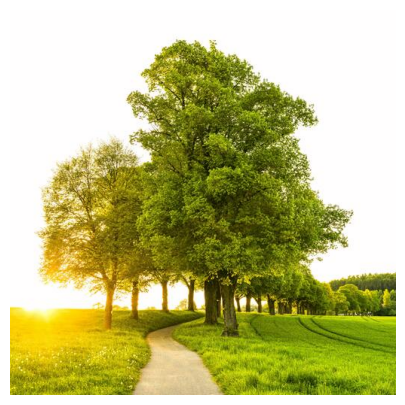

In [ ]:
transformed = transform(image=image1)["image"]
visualize(transformed)

In [ ]:
beta = 0.1

In [ ]:
height, width = image1.shape[:2]
border = int(np.floor(min(height, width) * beta))
center_y, center_x = height // 2, width // 2

# Define region for amplitude substitution
y1, y2 = center_y - border, center_y + border

x1, x2 = center_x - border, center_x + border

In [ ]:
x1, x2, y1, y2

(205, 307, 205, 307)

In [ ]:
def low_freq_mutate_np(amp_src, amp_trg, L, h, w):
    b = int(np.floor(min(h, w) * L))
    c_h, c_w = h // 2, w // 2
    h1, h2 = max(0, c_h - b), min(c_h + b, h - 1)
    w1, w2 = max(0, c_w - b), min(c_w + b, w - 1)
    amp_src[h1:h2, w1:w2] = amp_trg[h1:h2, w1:w2]
    return amp_src

def fourier_domain_adaptation(src_img, trg_img, beta=0.1):
    assert src_img.shape == trg_img.shape, "Source and target images must have the same shape."
    src_img = src_img.astype(np.float32)
    trg_img = trg_img.astype(np.float32)

    height, width, num_channels = src_img.shape
    
    # Prepare container for the output image
    src_in_trg = np.zeros_like(src_img)
    
    for c in range(num_channels):
        # Perform FFT on each channel
        fft_src = np.fft.fft2(src_img[:, :, c])
        fft_trg = np.fft.fft2(trg_img[:, :, c])
        
        # Shift the zero frequency component to the center
        fft_src_shifted = np.fft.fftshift(fft_src)
        fft_trg_shifted = np.fft.fftshift(fft_trg)
        
        # Extract amplitude and phase
        amp_src, pha_src = np.abs(fft_src_shifted), np.angle(fft_src_shifted)
        amp_trg = np.abs(fft_trg_shifted)
        
        # Mutate the amplitude part of the source with the target
        
        mutated_amp = low_freq_mutate_np(amp_src.copy(), amp_trg, beta, height, width)
        
        # Combine the mutated amplitude with the original phase
        fft_src_mutated = np.fft.ifftshift(mutated_amp * np.exp(1j * pha_src))
        
        # Perform inverse FFT
        src_in_trg_channel = np.fft.ifft2(fft_src_mutated)
        
        # Store the result in the corresponding channel of the output image
        src_in_trg[:, :, c] = np.real(src_in_trg_channel)
        
    return np.clip(src_in_trg, 0, 255)

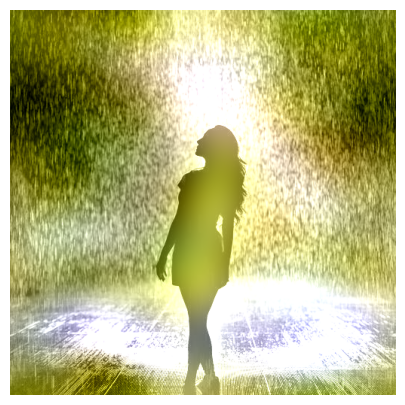

In [ ]:
visualize(fourier_domain_adaptation(image2, image1, 0.01).astype(np.uint8))